## Description
### Context
Company X owns a movie application and repository that caters to movie streaming to millions of users on a subscription basis. The company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on the cast information button, the app will show details of the actor in the scene. The company has in-house computer vision and multimedia experts who need to detect faces from screenshots of the movie scene.



#### Objective
Part A: To build a face detection system

Part B: To create an image dataset to be used by the AI team to build image classifier data

Part C: To build a face recognition system



#### Data Dictionary
Part A

label: Identifies the object in the image
notes: Additional comments (currently empty)
points: Co-ordinates of the mask (top-left and bottom-right)
imageWidth: Width of the image in pixels
imageHeight: Height of the image in pixels
Part B

The dataset comprises facial images that may contain either multiple individuals or a single individual per image.

Part C

This dataset consists of 10,770 images collected from Pinterest, featuring 100 individuals.

In [74]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
from tensorflow import reduce_sum
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, BatchNormalization, Activation, Reshape, UpSampling2D,
                                    Concatenate, ZeroPadding2D, MaxPooling2D, Dropout, Flatten)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from zipfile import ZipFile

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PART -A

### Q1-A Import and read 'images.npy'

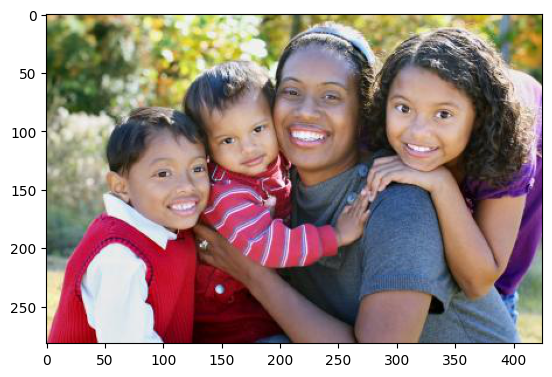

In [76]:
data = np.load('/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/Images.npy', allow_pickle= True)
plt.imshow(data[70][0])

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
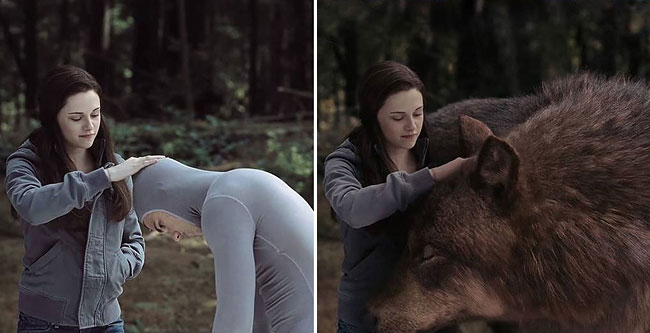

In [77]:
data[0][0]

In [78]:
data.shape

(393, 2)

### Part A - Q1 B - Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [79]:
IMG_SIZE = 224

Y = np.zeros((data.shape[0], IMG_SIZE, IMG_SIZE), dtype=np.float32)
X = np.zeros((data.shape[0], IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i in range(data.shape[0]):
    # Resizing image
    resized_img = cv2.resize(data[i][0], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    if len(resized_img.shape) == 2:
        X[i] = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
    elif resized_img.shape[2] == 4:
        X[i] = cv2.cvtColor(resized_img, cv2.COLOR_RGBA2RGB)
    else:
        X[i] = resized_img
    # Generating mask
    for bb in data[i][1]:
        x1 = int(bb['points'][0]['x'] * IMG_SIZE)
        y1 = int(bb['points'][0]['y'] * IMG_SIZE)
        x2 = int(bb['points'][1]['x'] * IMG_SIZE)
        y2 = int(bb['points'][1]['y'] * IMG_SIZE)
        Y[i][y1:y2, x1:x2] = 1

X = preprocess_input(X)

In [80]:
X[0]

array([[[-0.5764706 , -0.6156863 , -0.6392157 ],
        [-0.44313723, -0.4823529 , -0.5058824 ],
        [-0.56078434, -0.6       , -0.6156863 ],
        ...,
        [-0.79607844, -0.7176471 , -0.7176471 ],
        [-0.84313726, -0.7647059 , -0.7647059 ],
        [-0.79607844, -0.7254902 , -0.7176471 ]],

       [[-0.6       , -0.6392157 , -0.6627451 ],
        [-0.47450978, -0.5137255 , -0.5372549 ],
        [-0.5137255 , -0.5529412 , -0.5686275 ],
        ...,
        [-0.8352941 , -0.79607844, -0.81960785],
        [-0.84313726, -0.8039216 , -0.827451  ],
        [-0.7647059 , -0.73333335, -0.7490196 ]],

       [[-0.60784316, -0.64705884, -0.67058825],
        [-0.5294118 , -0.5686275 , -0.5921569 ],
        [-0.54509807, -0.58431375, -0.6       ],
        ...,
        [-0.77254903, -0.7882353 , -0.81960785],
        [-0.7647059 , -0.77254903, -0.8117647 ],
        [-0.73333335, -0.7411765 , -0.78039217]],

       ...,

       [[-0.5058824 , -0.5764706 , -0.6313726 ],
        [-0

In [81]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Part A - Q1 C - Split the data into train and test in 70:30 ratio.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

### Part A - Q1 D - Select random image from the train data and display original image and masked image.

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


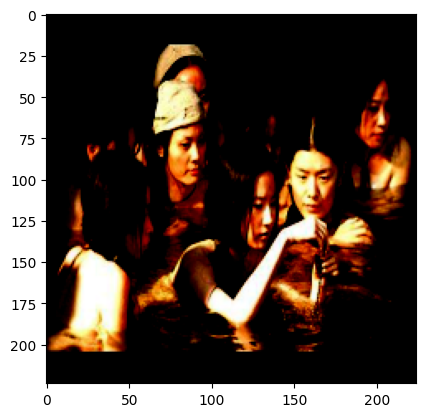

In [83]:
n = 19
print(X_train[n])
plt.imshow(X_train[n])

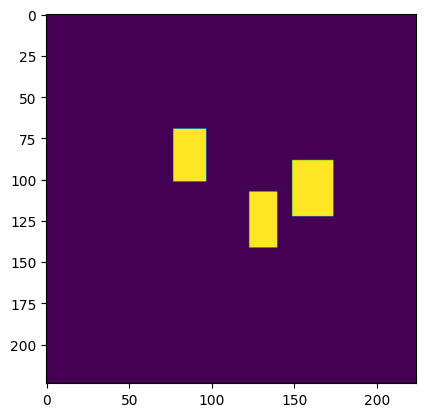

In [84]:
plt.imshow(y_train[n])

### Part A - Q2 A - Design a face mask detection model.
### Part A - Q2 B - Design your own Dice Coefficient and Loss function.

In [86]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [89]:
def build_decoder_block(n, skip, n_filters):

    y = Conv2DTranspose(filters=n_filters, kernel_size=2, strides=2, padding='same')(n)
    y = Concatenate()([y, skip])


    for i in range(2):
        y = Conv2D(filters=n_filters, kernel_size=3, padding='same')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

    return y

# Function to build MobileNet-UNet model
def build_model_unet(trainable=True):
    model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable


    en_block1 = model.get_layer("conv_pw_1_relu").output
    en_block2 = model.get_layer("conv_pw_3_relu").output
    en_block3 = model.get_layer("conv_pw_5_relu").output
    en_block4 = model.get_layer("conv_pw_11_relu").output


    en_block5 = model.get_layer("conv_pw_13_relu").output


    de_block = build_decoder_block(en_block5, en_block4, 112)
    de_block = build_decoder_block(de_block, en_block3, 56)
    de_block = build_decoder_block(de_block, en_block2, 28)
    de_block = build_decoder_block(de_block, en_block1, 14)
    de_block = UpSampling2D()(de_block)


    out = Conv2D(1, kernel_size=1, activation="sigmoid")(de_block)
    out = Reshape((IMG_SIZE, IMG_SIZE))(out)


    model = Model(inputs=model.input, outputs=out, name='MobileUNet')
    model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient, Recall(), Precision()])

    return model

In [90]:
mobile_unet = build_model_unet()
mobile_unet.summary()

Model: "MobileUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn         

 Total params: 4,708,189 (17.96 MB)

 Trainable params: 4,685,461 (17.87 MB)

 Non-trainable params: 22,728 (88.78 KB)

### Part A - Q2 C - Train and tune the model as required.

In [91]:
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [110]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

In [111]:
mobile_unet_history = mobile_unet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=16, verbose=1, callbacks=callbacks)

Epoch 1/15
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coefficient: 0.9442 - loss: 0.0820 - precision: 0.9647 - recall: 0.9657
Epoch 1: val_loss improved from inf to 0.71620, saving model to model-0.09.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - dice_coefficient: 0.9425 - loss: 0.0825 - precision: 0.9647 - recall: 0.9655 - val_dice_coefficient: 0.6814 - val_loss: 0.7162 - val_precision: 0.7291 - val_recall: 0.6676 - learning_rate: 1.0000e-06
Epoch 2/15
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - dice_coefficient: 0.9438 - loss: 0.0864 - precision: 0.9678 - recall: 0.9609
Epoch 2: val_loss improved from 0.71620 to 0.71514, saving model to model-0.09.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - dice_coefficient: 0.9424 - loss: 0.0866 - precision: 0.9675 - recall: 0.9612 - val_dice_coefficient: 0.6821 - val_loss: 0.7151 - val_precision: 0.7282 - val_recall: 0.6693 - learning_rate: 1.0000e-06
Epoch 3/15
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coefficient: 0.9436 

### Part A - Q2 D - Evaluate and share insights on performance of the model.

- Loss on training data is 8%, however Loss on Validation data is not improving from 71%
- Precison on training is 96%, which is quite good, however that seems to be reducig to 73% on validation
- We see similer trends for recall on training and validation, where recall on training is 96% and on validation 66%
- Dice Coeff on training data is 94%, and on validation 68%

### Part A - Q3 - Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


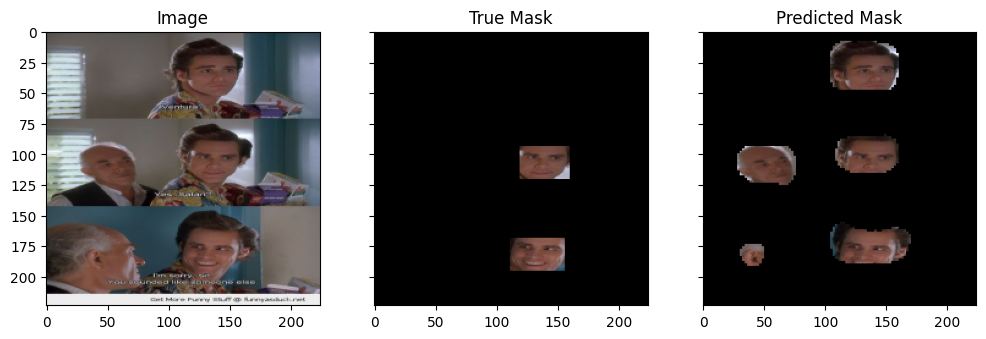

In [94]:
test_image = (X_test[3] + 1) / 2

pred_mask = np.float32(mobile_unet.predict(x=np.array([X_test[3]]))[0] > 0.6)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 12))
ax[0].imshow(test_image)
ax[0].set_title('Image')
ax[1].imshow(cv2.cvtColor(y_test[3], cv2.COLOR_GRAY2RGB) * test_image)
ax[1].set_title('True Mask');
ax[2].imshow(cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2RGB) * test_image)
ax[2].set_title('Predicted Mask');

## Part B

### Part B - Q1 - Read/import images from folder ‘training_images’.

In [95]:
import os
import glob
img_dir = '/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/training_images'
img_path = os.path.join(img_dir,'*g')
files = glob.glob(img_path)
training_images = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    training_images.append(img)

In [96]:
dir_list = next(os.walk(img_dir))[2]
dir_list

['real_00019.jpg',
 'real_00020.jpg',
 'real_00018.jpg',
 'real_00016.jpg',
 'real_00013.jpg',
 'real_00014.jpg',
 'real_00012.jpg',
 'real_00015.jpg',
 'real_00017.jpg',
 'real_00011.jpg',
 'real_00010.jpg',
 'real_00001.jpg',
 'real_00007.jpg',
 'real_00009.jpg',
 'real_00004.jpg',
 'real_00006.jpg',
 'real_00005.jpg',
 'real_00003.jpg',
 'real_00008.jpg',
 'real_00002.jpg',
 'real_00041.jpg',
 'real_00038.jpg',
 'real_00039.jpg',
 'real_00035.jpg',
 'real_00033.jpg',
 'real_00037.jpg',
 'real_00034.jpg',
 'real_00036.jpg',
 'real_00040.jpg',
 'real_00032.jpg',
 'real_00025.jpg',
 'real_00026.jpg',
 'real_00024.jpg',
 'real_00021.jpg',
 'real_00023.jpg',
 'real_00027.jpg',
 'real_00028.jpg',
 'real_00029.jpg',
 'real_00030.jpg',
 'real_00031.jpg',
 'real_00022.jpg',
 'real_00061.jpg',
 'real_00059.jpg',
 'real_00060.jpg',
 'real_00055.jpg',
 'real_00057.jpg',
 'real_00053.jpg',
 'real_00052.jpg',
 'real_00054.jpg',
 'real_00056.jpg',
 'real_00058.jpg',
 'real_00045.jpg',
 'real_00043

### Part B - Q2 - Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

### Part B - Q3 - From the same loop above, extract metadata of the faces and write into a DataFrame.

In [97]:
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]

for i in range (len(dir_list)):
    print("Execution loop =",i)
    # Create a cascade classfier object
    # Download: https://github.com/opencv/opencv/blob/4.x/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')   # frontal face
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)

    j=0
    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))

    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0

    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]


    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

Execution loop = 0
Execution loop = 1
Execution loop = 2
Execution loop = 3
Execution loop = 4
Execution loop = 5
Execution loop = 6
Execution loop = 7
Execution loop = 8
Execution loop = 9
Execution loop = 10
Execution loop = 11
Execution loop = 12
Execution loop = 13
Execution loop = 14
Execution loop = 15
Execution loop = 16
Execution loop = 17
Execution loop = 18
Execution loop = 19
Execution loop = 20
Execution loop = 21
Execution loop = 22
Execution loop = 23
Execution loop = 24
Execution loop = 25
Execution loop = 26
Execution loop = 27
Execution loop = 28
Execution loop = 29
Execution loop = 30
Execution loop = 31
Execution loop = 32
Execution loop = 33
Execution loop = 34
Execution loop = 35
Execution loop = 36
Execution loop = 37
Execution loop = 38
Execution loop = 39
Execution loop = 40
Execution loop = 41
Execution loop = 42
Execution loop = 43
Execution loop = 44
Execution loop = 45
Execution loop = 46
Execution loop = 47
Execution loop = 48
Execution loop = 49
Execution 

### Part B - Q4 - Save the output Dataframe in .csv format.

In [99]:
import pandas as pd

df = pd.DataFrame(x_cord, columns = ['x'])
df['y']=y_cord
df['w']=width
df['h']=height
df['Total_Faces']=face_detected
df['Image_Name']=image_name



In [100]:
df.head()

,x,y,w,h,Total_Faces,Image_Name
0,92,207,356,356,1,real_00019.jpg
1,210,117,181,181,2,real_00020.jpg
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,82,147,408,408,1,real_00013.jpg


In [102]:
df.to_csv("/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/Bounding_boxes.csv")

## Part C

### Part C - Q1 - Unzip, read and Load data(‘PINS.zip’) into session.

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/PINS.zip','r') as zip:
    zip.extractall()

### Part C - Q2 - Write function to create metadata of the image.

In [ ]:
import numpy as np
import pandas as pd
import os


class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

### Part C - Q3 - Write a loop to iterate through each and every image and create metadata for all the images.

In [ ]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [ ]:
metadata = load_metadata('PINS')
metadata

array([PINS/pins_Aaron Paul/Aaron Paul138_233.jpg,
       PINS/pins_Aaron Paul/Aaron Paul145_256.jpg,
       PINS/pins_Aaron Paul/Aaron Paul3_242.jpg, ...,
       PINS/pins_Melissa benoit/Melissa benoit62.jpg,
       PINS/pins_Melissa benoit/Melissa benoit8.jpg,
       PINS/pins_Melissa benoit/Melissa benoit91.jpg], dtype=object)

### Part C - Q4 - Generate Embeddings vectors on the each face in the dataset.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
model = vgg_face()
model.load_weights('/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/vgg_face_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
import cv2

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>],
 [<KerasTensor shape=(None, 2622), dtype=float32, sparse=False, name=keras_tensor_703>])

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
(2622,)


In [ ]:
total_images = len(metadata)

In [15]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Exception ignored in: <function _xla_gc_callback at 0x7bc5a7bddab0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

### Execution above cell stopped/interrupted due to resource constraints

In [16]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


### Part C - Q5 - Build distance metrics for identifying the distance between two similar and dissimilar images.

In [17]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

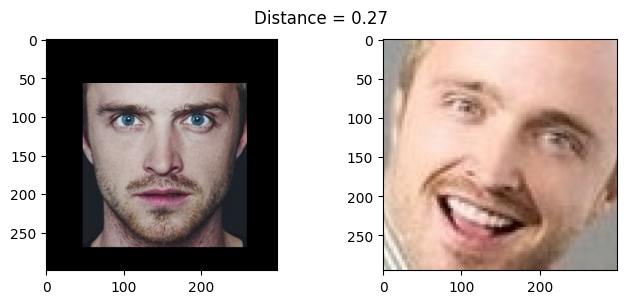

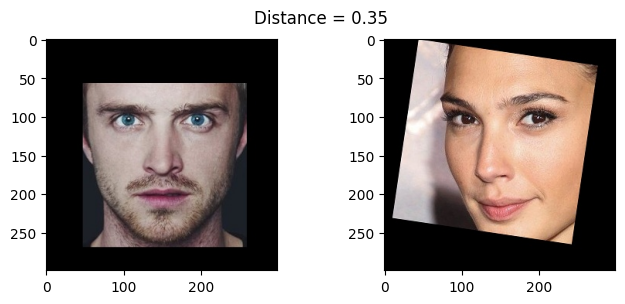

In [18]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

### Part C - Q6 - Use PCA for dimensionality reduction.

In [20]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]


print('X_train : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train : ({0},)'.format(y_train.shape[0]))
print('X_test : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test : ({0},)'.format(y_test.shape[0]))

X_train : (9573,2622)
y_train : (9573,)
X_test : (1197,2622)
y_test : (1197,)


In [22]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

In [23]:
# Standarize features
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### Part C - Q7 - Build an SVM classifier in order to map each image to its right person.

In [51]:
from sklearn.svm import SVC

#### Add your code here ####
classifier = SVC(C=7., gamma=0.0001, kernel='sigmoid')
classifier.fit(X_train_pca, y_train_enc)

SVC(C=7.0, gamma=0.0001, kernel='sigmoid')

In [52]:
y_predict = classifier.predict(X_test_pca)

In [53]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_enc)

y_predict :  [ 0  0  0 ... 76 76 76]
y_test_encoded :  [ 0  0  0 ... 37 37 37]


In [59]:
y_predict_enc = label_enc.inverse_transform(y_predict)

In [54]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
accuracy_score(y_test_enc, y_predict)

0.6399331662489557

### Part C - Q8 - Import and display the the test images.

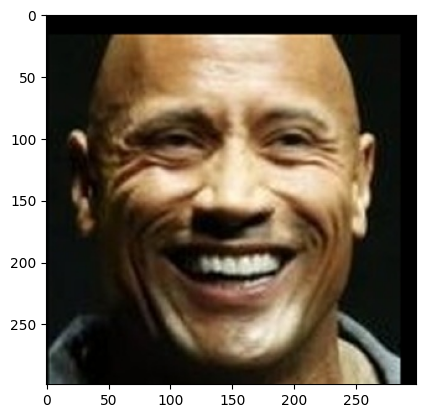

In [57]:
test_img1 = '/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/DwayneJohnson.jpg'
test_img2 = '/content/drive/My Drive/Great_Lakes_AIML_PG/computer_vision/project/BenedictCumberbatch.jpg'

plt.imshow(load_image(test_img1))


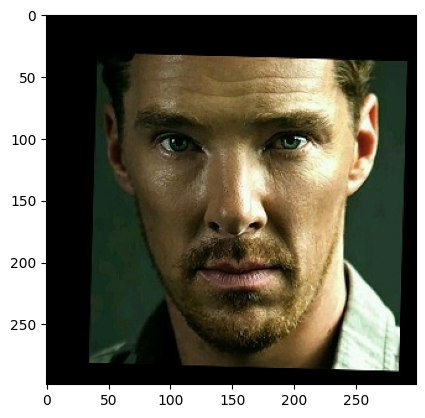

In [58]:
plt.imshow(load_image(test_img2))

### Part C - Q9 - Use the trained SVM model to predict the face on both test images.

In [71]:
import cv2
import numpy as np


def predict_display_img(img_path):
  img = load_image(img_path)
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize=(224, 224))

  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

  embedding_std = std_scaler.transform(embedding_vector.reshape(1, -1))

  embedding_pca = pca.transform(embedding_std)

  prediction = classifier.predict(embedding_pca)[0]

  predicted_name = label_enc.inverse_transform([prediction])[0]

  plt.imshow(load_image(img_path))
  plt.title(f'Identified as {predicted_name}');


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


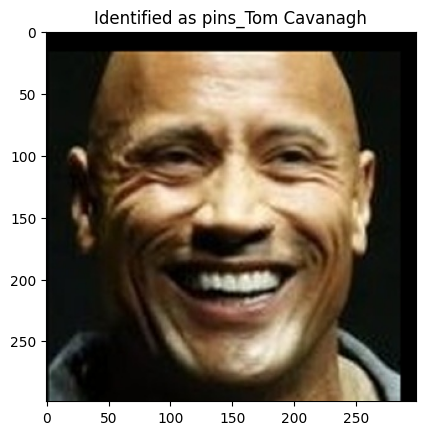

In [72]:
predict_display_img(test_img1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


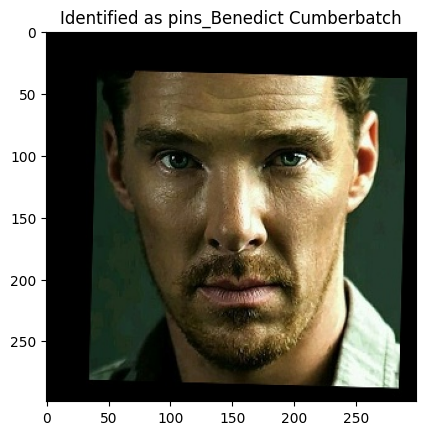

In [73]:
predict_display_img(test_img2)